In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from transformers import pipeline
import numpy as np

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Load SQUAD (Question and Answer) Dataset



In [ ]:
dataset = load_dataset("rajpurkar/squad",  split="validation[:51]")

In [ ]:
sample = dataset[0]
print("Title:", sample["title"])
print("Context:", sample["context"])
print("Question:", sample["question"])
print("Answers:", sample["answers"])

Title: Super_Bowl_50
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question: Which NFL team represented the AFC at Super Bowl 50?
Answers: {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}


In [ ]:
sample_50 = dataset[50]
print("Title:", sample_50["title"])
print("Context:", sample_50["context"])
print("Question:", sample_50["question"])
print("Answers:", sample_50["answers"])

Title: Super_Bowl_50
Context: The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl.
Question: Who did Denver beat in the 2015 AFC Championship game?
Answers: {'text': ['New England Patriots', 'the New England Patriots', 'New England Patriots'], 'answer_start': [372, 368, 372]}


## Loading Model (AutoModel)

In [ ]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModel.from_pretrained(model_id, output_attentions=True, torch_dtype=torch.bfloat16, device_map="auto", attn_implementation="eager")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

## Tokenize and get Attention output

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

# Extract attention for each example
all_attentions = []
tokens_list = []

for i, example in enumerate(dataset):
    question = example["question"]
    context = example["context"]

    # Tokenize inputs
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True, padding=True).to(device)

    # Pass through model and extract attentions
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions  # List of attention tensors (one per layer)
        all_attentions.append(attentions)
        tokens_list.append(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))



In [ ]:
print("Sample of how input looks after tokenizing", inputs)

Sample of how input looks after tokenizing {'input_ids': tensor([[128000,  15546,   1550,  22898,   9567,    304,    279,    220,    679,
             20,  64636,  19134,   1847,     30, 128000,    791,  45267,   8220,
            279,   5912,   3280,    449,    264,    220,    868,   4235,     16,
           3335,     11,    323,  20046,   8215,  21324,    574,   7086,    279,
          12873,   7648,   4196,  13429,   7460,    320,     44,  13683,    570,
           2435,  24164,    279,  17368,  44427,    220,   2491,   4235,    868,
            304,    279,  48305,  19134,   4140,    323,  11084,    311,    872,
           2132,   7445,  20904,  11341,   2533,    279,  19562,    574,  18538,
            304,    220,   2550,     20,     13,    578,  42694,   8220,    279,
           5912,   3280,    449,    264,    220,    717,   4235,     19,   3335,
             11,    323,  15164,    279,   1561,   9635,  33617,    264,   6140,
            311,  10726,    872,   2316,    505,   7

In [ ]:
len(tokens_list)

51

In [ ]:
print(len(all_attentions[0]))


16


In [ ]:
print(outputs.keys())

odict_keys(['last_hidden_state', 'past_key_values', 'attentions'])


In [ ]:
"""Attention weights are a list of tensors with shape (batch_size, num_heads, seq_length, seq_length). """
if 'attentions' in outputs:
    print(type(outputs.attentions))
    print(len(outputs.attentions))
    print(outputs.attentions[0].shape)

## Only considering one datapoint

In [ ]:
example = dataset[0]
question = example['question']
context = example['context']
answer = "Denver Broncos"

In [ ]:
example

{'id': '56be4db0acb8001400a502ec',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?',
 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],


In [ ]:
question

'Which NFL team represented the AFC at Super Bowl 50?'

In [ ]:
context

'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.'




# Experiment 1: Compare Attention Patterns Across Different LLMs
## Visualizing the Attention using Heatmap
(a) Analyze and compare how different LLMs allocate their attention to input tokens in similar contexts or tasks. <br>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Heatmap visualization for Sample 50 , Layer 0 and Head 0 (Input Sequence)


In [ ]:
# Sample 50
example = dataset[50]
question = example['question']
context = example['context']
answer = example['answers']['text'][0]
print('Question - ', question)
print('Context - ', context)
print('Answer - ', answer)

Question -  Who did Denver beat in the 2015 AFC Championship game?
Context -  The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl.
Answer -  New England Patriots


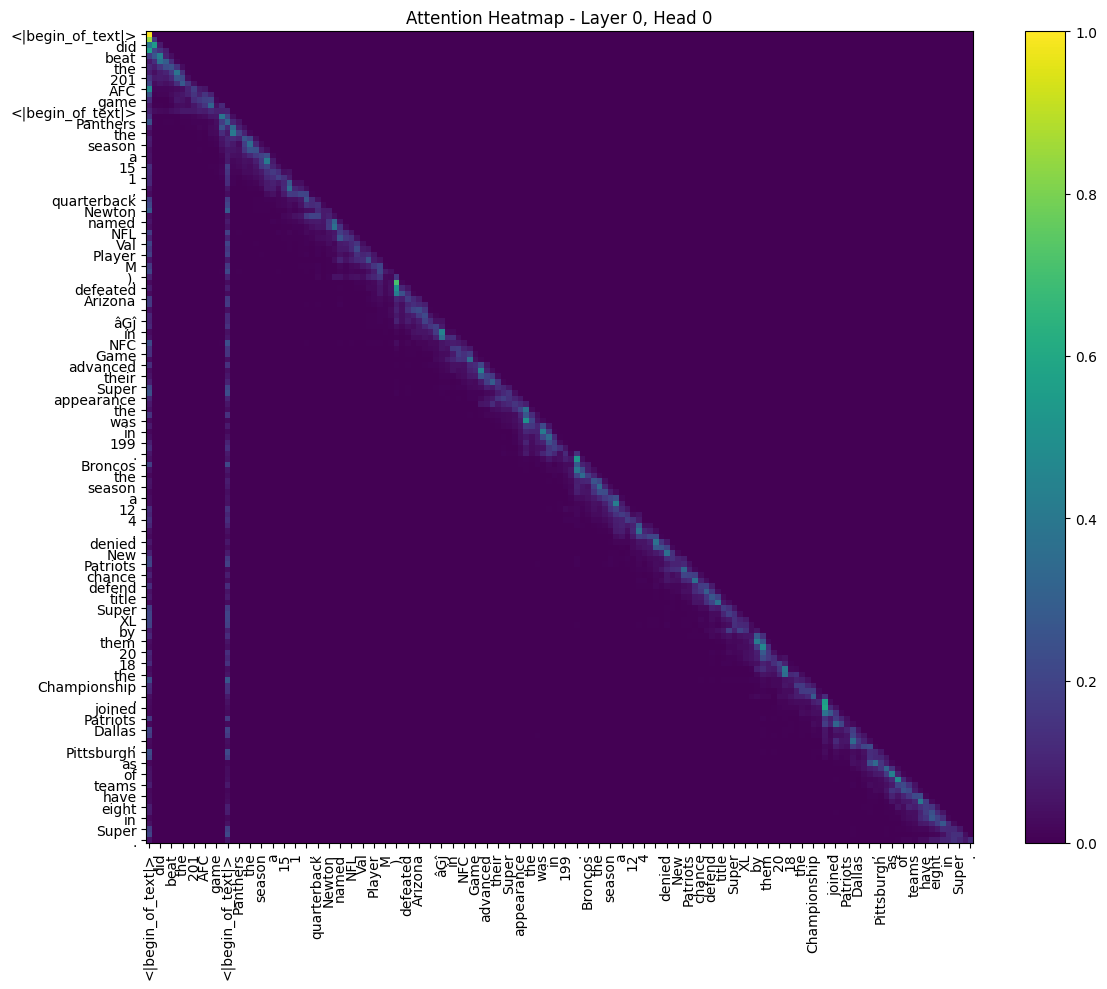

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_index = 50
sample_attention = all_attentions[sample_index]
sample_tokens = [token.replace("Ġ", "") for token in tokens_list[sample_index]]

layer_num = 0  # First layer (0-indexed)
head_num = 0   # First attention head (0-indexed)

# Extract attention weights for the first layer and head
attention_weights = sample_attention[layer_num][0, head_num].to(torch.float32).cpu().detach().numpy()

# Plot the attention heatmap
plt.figure(figsize=(12, 10))
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
token_indices = np.arange(len(sample_tokens))
step = 2  # Show every 5th token
plt.xticks(token_indices[::step], sample_tokens[::step], rotation=90)
plt.yticks(token_indices[::step], sample_tokens[::step])
plt.title(f"Attention Heatmap - Layer {layer_num}, Head {head_num}")
plt.tight_layout()
plt.show()


### Heatmap visualization for Sample 50 , Layer 15 and Head 1 (Input Sequence)


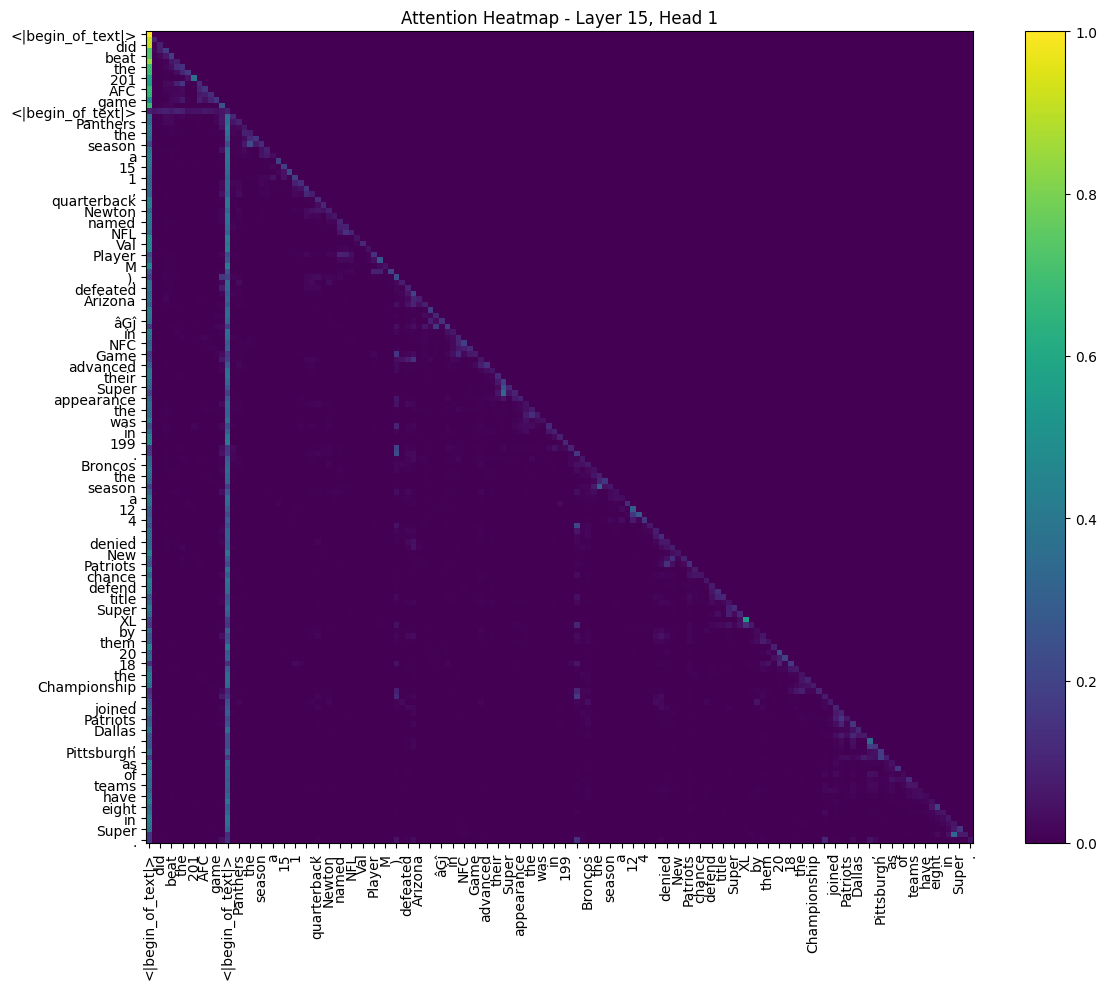

In [ ]:
sample_index = 50
sample_attention = all_attentions[sample_index]
sample_tokens = [token.replace("Ġ", "") for token in tokens_list[sample_index]]

layer_num = 15  # Second layer (0-indexed)
head_num = 1   # Second attention head (0-indexed)

# Extract attention weights for the first layer and head
attention_weights = sample_attention[layer_num][0, head_num].to(torch.float32).cpu().detach().numpy()

# Plot the attention heatmap
plt.figure(figsize=(12, 10))
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
token_indices = np.arange(len(sample_tokens))
step = 2  # Show every 5th token
plt.xticks(token_indices[::step], sample_tokens[::step], rotation=90)
plt.yticks(token_indices[::step], sample_tokens[::step])
plt.title(f"Attention Heatmap - Layer {layer_num}, Head {head_num}")
plt.tight_layout()
plt.show()

### Aggregate attention across all heads in the specified layer

#### Layer 1

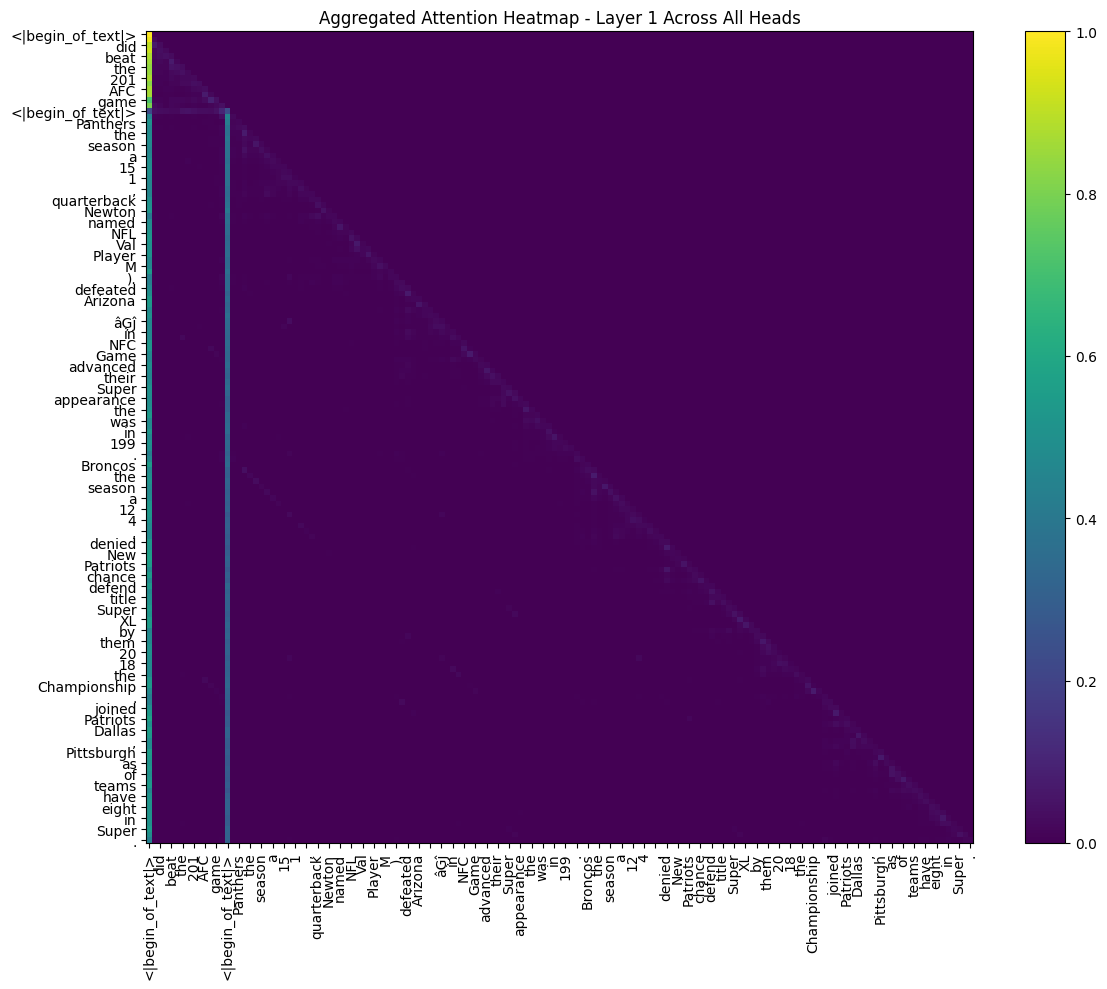

In [ ]:
sample_index = 50
sample_attention = all_attentions[sample_index]
sample_tokens = [token.replace("Ġ", "") for token in tokens_list[sample_index]]

layer_num = 1  # Specify the layer number

# Aggregate attention across all heads by taking the mean
attention_weights = sample_attention[layer_num][0].mean(dim=0).to(torch.float32).cpu().detach().numpy()

# Plot the aggregated attention heatmap
plt.figure(figsize=(12, 10))
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
token_indices = np.arange(len(sample_tokens))
step = 2  # Adjust step size to control the number of tokens displayed
plt.xticks(token_indices[::step], sample_tokens[::step], rotation=90)
plt.yticks(token_indices[::step], sample_tokens[::step])
plt.title(f"Aggregated Attention Heatmap - Layer {layer_num} Across All Heads")
plt.tight_layout()
plt.show()


#### Layer 15

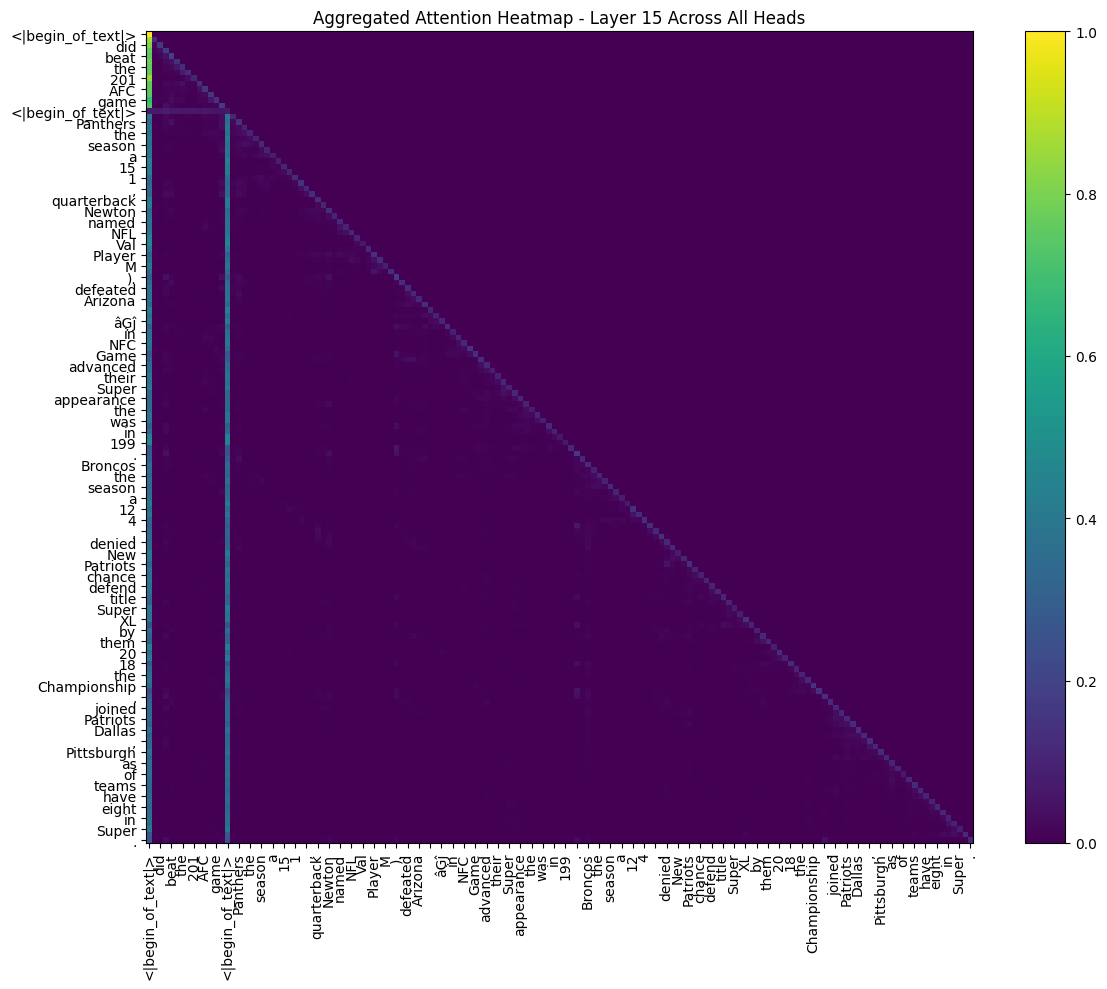

In [ ]:
sample_index = 50
sample_attention = all_attentions[sample_index]
sample_tokens = [token.replace("Ġ", "") for token in tokens_list[sample_index]]

layer_num = 15  # Specify the layer number

# Aggregate attention across all heads by taking the mean
attention_weights = sample_attention[layer_num][0].mean(dim=0).to(torch.float32).cpu().detach().numpy()

# Plot the aggregated attention heatmap
plt.figure(figsize=(12, 10))
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar()
token_indices = np.arange(len(sample_tokens))
step = 2  # Adjust step size to control the number of tokens displayed
plt.xticks(token_indices[::step], sample_tokens[::step], rotation=90)
plt.yticks(token_indices[::step], sample_tokens[::step])
plt.title(f"Aggregated Attention Heatmap - Layer {layer_num} Across All Heads")
plt.tight_layout()
plt.show()

## Attention paid to specific types of tokens
(b) Identify patterns such as how much attention is paid to specific types of tokens (e.g., nouns, verbs, punctuation).





In [ ]:
import spacy
import matplotlib.pyplot as plt
import numpy as np

# Load spaCy model for POS tagging
nlp = spacy.load("en_core_web_sm")

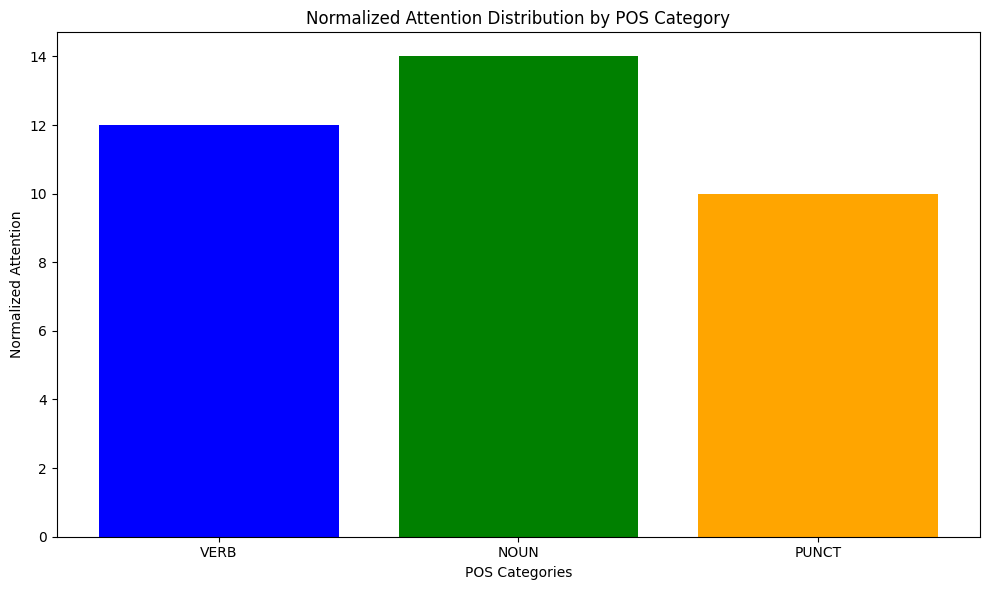

In [ ]:
# Tokenize using spaCy
doc = nlp(" ".join(sample_tokens))
pos_tags = [token.pos_ for token in doc]

# Define POS categories of interest
pos_categories = {"NOUN", "VERB", "PUNCT"}

# Initialize a dictionary to store attention sums per POS category
attention_sums = {category: 0 for category in pos_categories}

# Aggregate attention across all heads for the specified layer
# Shape after aggregation: (seq_length, seq_length)
layer_num = 15
aggregated_attention = sample_attention[layer_num].mean(dim=1).to(torch.float32).cpu().detach().numpy()

# Filter tokens and aggregate attention weights
for i, (token, pos) in enumerate(zip(sample_tokens, pos_tags)):
    if pos in pos_categories:
        # Sum attention weights pointing to this token across all heads (adjust indexing as needed)
        attention_weight = np.sum(aggregated_attention[:, i])  # Summing over all heads
        attention_sums[pos] += attention_weight

# Prepare data for plotting
categories = list(attention_sums.keys())
summed_attention = list(attention_sums.values())

# Normalize the attention sums to the total attention for better comparability
# total_attention = sum(summed_attention)
# normalized_attention = [attn / total_attention for attn in summed_attention]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, summed_attention, color=['blue', 'green', 'orange'])

# Adding labels and title
plt.title("Normalized Attention Distribution by POS Category")
plt.xlabel("POS Categories")
plt.ylabel("Normalized Attention")
plt.tight_layout()
plt.show()


# Experiment 2 & 3 - Compare Attention Using Different Interpretability Methods


## Integrated Gradients-based method

## 1. Inseq

In [ ]:
pip install git+https://github.com/inseq-team/inseq.git

  Cloning https://github.com/inseq-team/inseq.git to /tmp/pip-req-build-23zn9zhi
  Running command git clone --filter=blob:none --quiet https://github.com/inseq-team/inseq.git /tmp/pip-req-build-23zn9zhi
  Resolved https://github.com/inseq-team/inseq.git to commit 1078e1917834f00139dd369e7eb3e48abfed795c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load Model (With Langugae Model Head - AutoModelForCausalLM)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto"
).to(device)

In [ ]:
sample = dataset[0]
print("Title:", sample["title"])
print("Context:", sample["context"])
print("Question:", sample["question"])
print("Answers:", sample["answers"])

Title: Super_Bowl_50
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question: Which NFL team represented the AFC at Super Bowl 50?
Answers: {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}


In [ ]:
import inseq
attribution_model = inseq.load_model(
    model=model,
    tokenizer=tokenizer,
    attribution_method="integrated_gradients"
)

In [ ]:
attributions = attribution_model.attribute(
    sample["question"],
    n_steps=100,
    skip_special_tokens=True
)
attributions.show()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with integrated_gradients...: 100%|██████████| 20/20 [00:02<00:00,  3.09it/s]


,,0,1,2,3,4,5,6,7
,,ĠThe,ĠDenver,ĠBroncos,.ĊĊ,The,ĠBroncos,Ġdefeated,Ġthe
0,Which,0.199,0.14,0.125,0.193,0.142,0.119,0.1,0.075
1,ĠNFL,0.117,0.097,0.109,0.112,0.104,0.066,0.059,0.088
2,Ġteam,0.085,0.047,0.056,0.067,0.06,0.036,0.042,0.048
3,Ġrepresented,0.113,0.08,0.047,0.12,0.078,0.05,0.076,0.049
4,Ġthe,0.068,0.06,0.06,0.051,0.043,0.035,0.037,0.037
5,ĠAFC,0.057,0.069,0.053,0.036,0.04,0.044,0.037,0.035
6,Ġat,0.043,0.057,0.05,0.055,0.038,0.035,0.038,0.041
7,ĠSuper,0.04,0.062,0.065,0.027,0.029,0.03,0.04,0.032
8,ĠBowl,0.055,0.083,0.059,0.037,0.035,0.041,0.049,0.045


In [ ]:
attribution_model_2 = inseq.load_model(
    model=model,
    tokenizer=tokenizer,
    attribution_method="saliency"
)

In [ ]:
attributions_sal = attribution_model_2.attribute(
    sample["question"],
    n_steps=100,
    skip_special_tokens=True
)
attributions_sal.show()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Attributing with saliency...: 100%|██████████| 20/20 [00:00<00:00, 14.68it/s]


,,0,1,2,3,4,5,6,7
,,ĠThe,ĠDenver,ĠBroncos,.,ĠThe,Ġgame,Ġwas,Ġplayed
0,Which,0.186,0.133,0.172,0.172,0.184,0.154,0.121,0.112
1,ĠNFL,0.121,0.1,0.093,0.105,0.092,0.102,0.068,0.08
2,Ġteam,0.074,0.042,0.041,0.07,0.05,0.05,0.049,0.051
3,Ġrepresented,0.111,0.074,0.07,0.108,0.081,0.095,0.092,0.084
4,Ġthe,0.052,0.049,0.039,0.053,0.041,0.058,0.043,0.044
5,ĠAFC,0.058,0.058,0.049,0.031,0.034,0.048,0.035,0.046
6,Ġat,0.043,0.046,0.033,0.041,0.04,0.035,0.038,0.044
7,ĠSuper,0.039,0.058,0.038,0.027,0.024,0.034,0.042,0.053
8,ĠBowl,0.052,0.078,0.057,0.033,0.031,0.041,0.046,0.062


## Captum

In [ ]:
pip install captum

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
from captum.attr import (
    FeatureAblation,
    ShapleyValues,
    LayerIntegratedGradients,
    LLMAttribution,
    LLMGradientAttribution,
    TextTokenInput,
    TextTemplateInput,
    ProductBaselines,
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
context = sample["context"]
question = sample["question"]
answer = "Denver Broncos"

In [ ]:
inputs = tokenizer(question, context, return_tensors="pt").to(device)
print(inputs)

{'input_ids': tensor([[128000,  23956,  12873,   2128,  15609,    279,  64636,    520,   7445,
          20904,    220,   1135,     30, 128000,  19841,  20904,    220,   1135,
            574,    459,   3778,   9141,   1847,    311,   8417,    279,  18824,
            315,    279,   5165,  21424,   9130,    320,  88201,      8,    369,
            279,    220,    679,     20,   3280,     13,    578,   3778,  21424,
          15217,    320,     32,   6897,      8,  18824,  22898,  42694,  24164,
            279,   5165,  21424,  15217,    320,     45,   6897,      8,  18824,
          13030,  45267,    220,   1187,   4235,    605,    311,   7380,    872,
           4948,   7445,  20904,   2316,     13,    578,   1847,    574,   6476,
            389,   7552,    220,     22,     11,    220,    679,     21,     11,
            520,  56141,    596,  23462,    304,    279,   5960,  13175,   9332,
          12299,    520,  16376,  51657,     11,   7188,     13,   1666,    420,
            57

In [ ]:
# Explicitly set the pad_token_id and attention_mask
inputs["pad_token_id"] = tokenizer.eos_token_id
inputs["attention_mask"] = inputs["attention_mask"].to(device)

with torch.no_grad():
    output_ids = model.generate(inputs["input_ids"], max_new_tokens=5,attention_mask=inputs['attention_mask'] )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Extract the answer from the response
print(response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Which NFL team represented the AFC at Super Bowl 50?Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50. The game was watched by


In [ ]:
def forward_with_embeddings(inputs_embeds, attention_mask):
    # Ensure tensors are on the correct device
    inputs_embeds = inputs_embeds.to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, output_hidden_states=True)

    # Access the hidden states (the last layer's hidden states)
    hidden_states = outputs.hidden_states[-1]

    return hidden_states.mean(dim=1)


In [ ]:
ig = IntegratedGradients(forward_with_embeddings)

In [ ]:
inputs_embeds = model.get_input_embeddings()(inputs["input_ids"])

In [ ]:
torch.cuda.empty_cache()


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
import gc
gc.collect()  # Manually clean up memory

380

In [ ]:
with torch.no_grad():
    attributions, delta = ig.attribute(
        inputs=inputs_embeds,
        additional_forward_args=(inputs["attention_mask"],),
        target=0,
        return_convergence_delta=True,
        internal_batch_size=4,
    )

In [ ]:
print(attributions.shape)

torch.Size([1, 177, 2048])


### Visualization

In [ ]:
# Normalize attributions for visualization
attribution_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Normalize the attributions for better visualization (optional)
attributions_norm = (attribution_scores - attribution_scores.min()) / (attribution_scores.max() - attribution_scores.min())


In [ ]:
for token, score in zip(tokens, attributions_norm):
    print(f"{token}: {score}")

<|begin_of_text|>: 0.4019376071679858
Which: 0.0
ĠNFL: 1.0
Ġteam: 0.2802140993802959
Ġrepresented: 0.45192122795628775
Ġthe: 0.4664528538077054
ĠAFC: 0.5249591726163108
Ġat: 0.37005105586115117
ĠSuper: 0.4628535842074452
ĠBowl: 0.54981172208003
Ġ: 0.6261513150775546
50: 0.4658208011083937
?: 0.4710120492322547
<|begin_of_text|>: 0.6067564748591182
Super: 0.5587325089875951
ĠBowl: 0.48680010834625737
Ġ: 0.5889397200684559
50: 0.47915640265275894
Ġwas: 0.43995888735511907
Ġan: 0.5920010543084105
ĠAmerican: 0.44001742229500335
Ġfootball: 0.398184929590351
Ġgame: 0.5077515108708656
Ġto: 0.4396701810796104
Ġdetermine: 0.4524440931073287
Ġthe: 0.4978070796167176
Ġchampion: 0.5030156011836431
Ġof: 0.45474122006526513
Ġthe: 0.5218534813287525
ĠNational: 0.4449974035913074
ĠFootball: 0.46751070216157753
ĠLeague: 0.5419914510303917
Ġ(: 0.4675041711304706
NFL: 0.4878575842033111
): 0.5001779438688129
Ġfor: 0.4606343405700207
Ġthe: 0.4857795772821175
Ġ: 0.5476245316244923
201: 0.49331344566805874


In [ ]:
import plotly.graph_objects as go

def plot_interactive_attributions(tokens, attributions):

    # Clean up tokens and handle any non-string tokens
    tokens = [token.replace("Ġ", "") for token in tokens]
    tokens = [token if isinstance(token, str) else str(token) for token in tokens]

    # Optionally, truncate tokens to a certain length if they are too long
    tokens = [token[:20] for token in tokens]  # truncate long tokens to 20 characters

    fig = go.Figure(data=[go.Bar(
        x=tokens,
        y=attributions,
        hoverinfo='x+y',  # Show token and attribution score on hover
        marker=dict(color=attributions, colorscale='Viridis', colorbar=dict(title="Attribution")),
    )])

    fig.update_layout(
        title="Token-Level Attribution Scores",
        xaxis_title="Tokens",
        yaxis_title="Attribution Score",
        xaxis=dict(tickangle=90),
        showlegend=False,
        height=600  # Adjust height for better readability
    )

    fig.show()

# plot the attributions
plot_interactive_attributions(tokens, attribution_scores)


## Layer Gradient-based Method

In [ ]:
context = sample["context"]
question = sample["question"]
answer = "Denver Broncos"

In [ ]:
lig = LayerIntegratedGradients(model, model.model.embed_tokens)

llm_attr = LLMGradientAttribution(lig, tokenizer)

In [ ]:
# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

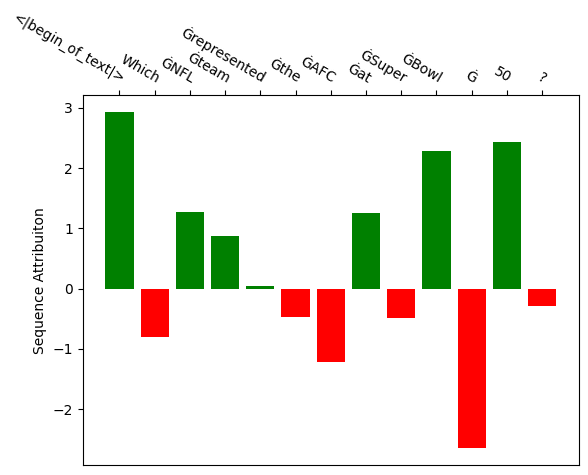

In [ ]:
inp = TextTokenInput(
    question,
    tokenizer,
)

attr_res = llm_attr.attribute(inp, target = answer)

attr_res.plot_seq_attr(show=True)

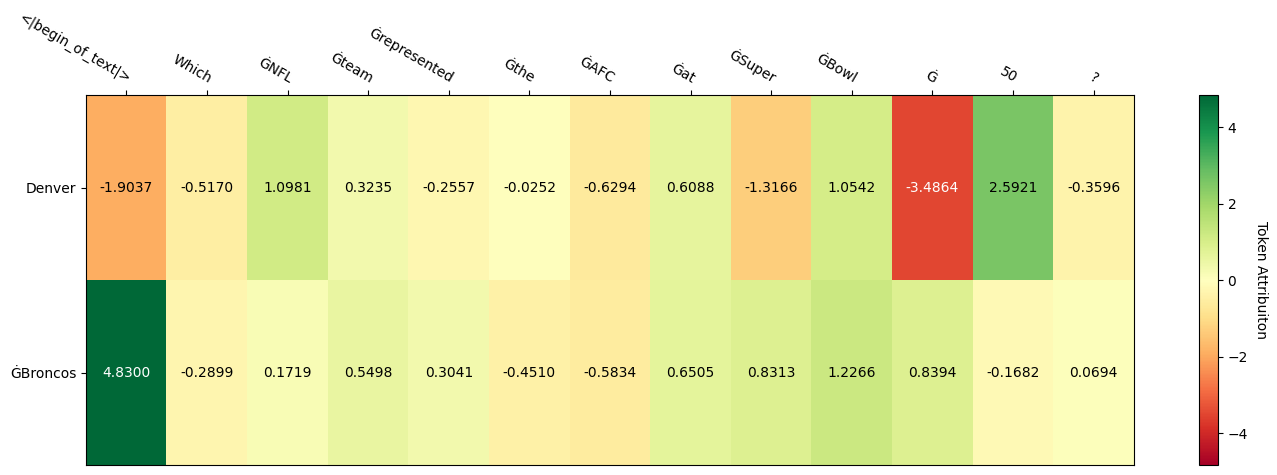

In [ ]:
attr_res.plot_token_attr(show=True)

## Attention Rollout Method

In [ ]:
example = dataset[0]
question = example['question']
context = example['context']
answer = "Denver Broncos"

In [ ]:
# Tokenize inputs
inputs = tokenizer(question, context, return_tensors="pt", truncation=True, padding=True).to(device)

# Extract attentions for each example
all_attentions = []
tokens_list = []

# Pass through model and extract attentions
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)  # Ensure output_attentions=True
    attentions = outputs.attentions  # List of attention tensors (one per layer)
    all_attentions.append(attentions)
    tokens_list.append(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))  # Convert ids to tokens


In [ ]:
len(all_attentions)

1

In [ ]:
def attention_rollout(attentions):
    """
    Computes the attention rollout given a list of attention matrices.
    This function assumes each attention matrix has shape (num_heads, seq_len, seq_len),
    and it sums over the heads before applying the matrix multiplication.
    """
    # Initialize the rollout matrix with the first layer's attention (summed over heads)
    rollout = attentions[0][0].sum(dim=1)  # Sum over attention heads for the first layer (Shape: seq_len, seq_len)

    # Recursively multiply attention matrices to compute the rollout
    for attn in attentions[1:]:
        # Sum over heads for the current layer
        attn = attn.sum(dim=1)  # Shape: seq_len, seq_len
        rollout = torch.matmul(attn, rollout)

    return rollout


In [ ]:
rollout = attention_rollout(all_attentions)

In [ ]:
print(rollout.shape)

torch.Size([1, 177, 177])


In [ ]:
rollout[0].shape

torch.Size([177, 177])

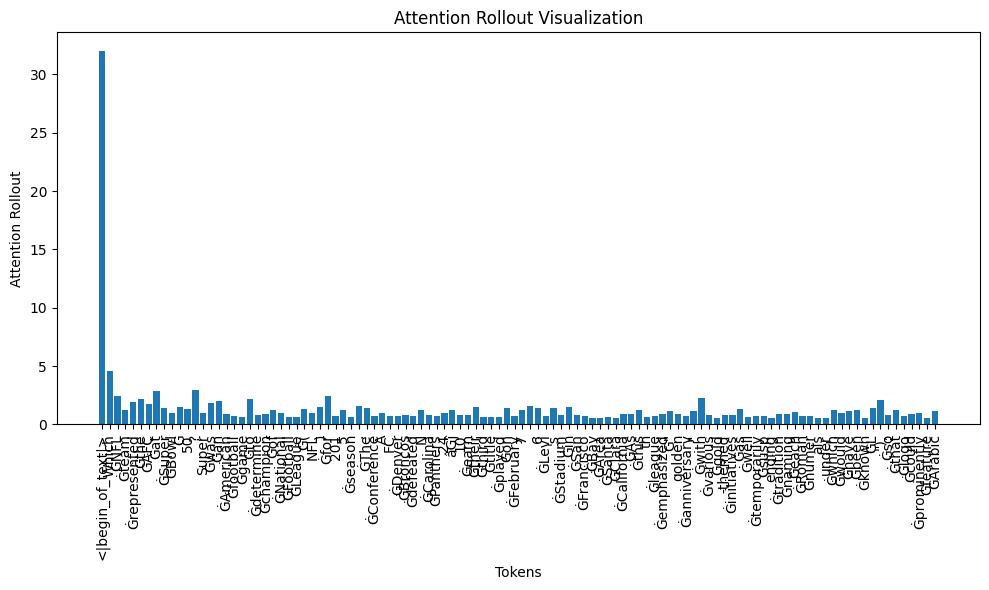

In [ ]:
import matplotlib.pyplot as plt

def plot_rollout(rollout, tokens):
    """Plots the attention rollout as a bar graph."""

    # Assuming rollout is a tensor of shape (sequence_length, sequence_length)
    # and tokens is a list of tokens (strings)

    # Extract the diagonal elements (self-attention)
    # You might need to adjust this based on the meaning of the rollout for your case.
    # For example, you can take the sum or mean of the attention weights across all tokens.
    self_attention = torch.diag(rollout)

    plt.figure(figsize=(10, 6))
    plt.bar(tokens, self_attention.type(torch.float32).cpu().detach().numpy()) # Convert tensor to numpy for plotting
    plt.xlabel("Tokens")
    plt.ylabel("Attention Rollout")
    plt.title("Attention Rollout Visualization")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have 'rollout' and 'tokens_list' defined):
# Assuming tokens_list is the list of tokens corresponding to the rollout
plot_rollout(rollout[0], tokens_list[0])

# Experiment 3: Analyze Attention Patterns During Text Generation

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto"
).to(device)

In [ ]:
example = dataset[0]
question = example['question']
context = example['context']
answer = "Denver Broncos"

In [ ]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): Lla

## Experiment 4: Identify Attention Patterns in Downstream Tasks


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

In [ ]:
# Load the Llama model and tokenizer
model_id = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with your Llama model version
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto").eval()


In [ ]:
# Define a prompt for text generation
prompt = "I like Natural Language Processing because,"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

# Generate text using the model
generated_ids = model.generate(input_ids, max_length=100, num_return_sequences=1)

# Decode the generated tokens to text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Text:
I like Natural Language Processing because, well, it's just so cool! I mean, imagine being able to write a program that can understand and analyze human language in a way that's similar to how we think. It's like having a superpower!

But, I've also heard that Natural Language Processing (NLP) can be a bit of a challenge. People often talk about how it's like trying to teach a computer to understand human language, but that's not entirely accurate. While


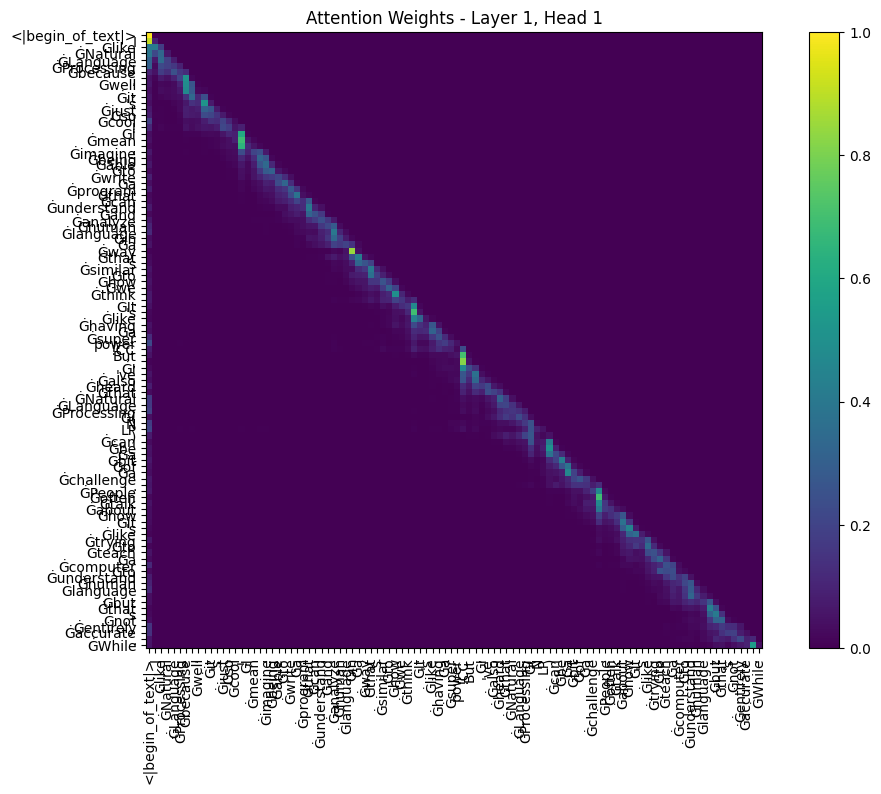

In [ ]:
# Get the attention weights and explain the result using transformers-interpret
# Since the Llama model is a causal language model, we treat this as a sequence generation problem.

class LlamaTextGenerationExplainer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def explain(self, input_text):
        # Tokenize the input text
        inputs = self.tokenizer(input_text, return_tensors="pt").to(self.model.device)

        # Get model predictions (in this case we only care about the attention)
        outputs = self.model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], output_attentions=True)

        attentions = outputs.attentions  # Attention weights from all layers
        return attentions, inputs["input_ids"]

# Initialize the explainer
explainer = LlamaTextGenerationExplainer(model, tokenizer)

# Get attention weights for the generated text
attentions, input_ids = explainer.explain(generated_text)

# Visualize attention for a specific layer and head
def visualize_attention(attentions, tokenizer, input_ids, layer=0, head=0):
    """
    Visualize attention weights for a specific layer and head.
    :param attentions: Tuple of attention tensors from the model.
    :param tokenizer: Tokenizer used for encoding.
    :param input_ids: Input token IDs.
    :param layer: Layer index to visualize.
    :param head: Attention head index to visualize.
    """
    # Extract attention from specified layer and head
    attn_weights = attentions[layer][0][head].detach().cpu().numpy()  # Shape: (seq_len, seq_len)

    # Decode tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Plot attention matrix
    plt.figure(figsize=(12, 8))
    plt.imshow(attn_weights, cmap="viridis")  # attn_weights is now a 2D array
    plt.colorbar()
    # step = 2  # Show every 5th token
    # plt.xticks(token_indices[::step], sample_tokens[::step], rotation=90)
    # plt.yticks(token_indices[::step], sample_tokens[::step])
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=10)
    plt.yticks(range(len(tokens)), tokens, fontsize=10)
    plt.title(f"Attention Weights - Layer {layer + 1}, Head {head + 1}")
    plt.show()

# Visualize attention for the first layer and first head
visualize_attention(attentions, tokenizer, input_ids, layer=0, head=0)
